# Federated Learning Practice on MNIST dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
import syft as sy
import copy
hook = sy.TorchHook(torch)

In [ ]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
# create a couple workers
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
secure_worker_a = sy.VirtualWorker(hook, id="secure_worker_a")
secure_worker_b = sy.VirtualWorker(hook, id="secure_worker_b")

In [ ]:
# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std


# choose the training and test datasets

federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/zhaojia-raoxy/data', train=True, download=True,
                   transform=train_transforms)
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=20, shuffle=True, **kwargs)


federated_test_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/zhaojia-raoxy/data', train=False, download=True,
                   transform=test_transforms)
    .federate((secure_worker_a, secure_worker_b)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=20, shuffle=False, **kwargs)

# 训练模型
## Net

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
       # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        # convolutional layer (sees 14x14x4 tensor after MaxPool)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (7 * 7 * 16)
        self.fc1 = nn.Linear(7 * 7 * 16, 512)
        # linear layer (512 -> 10)
        self.fc2 = nn.Linear(512, 10)
        # dropout layer (p=0.20)
        self.dropout = nn.Dropout(0.20)
        
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = x.view(-1, 7 * 7 * 16)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        # LogSoftMax
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03) # TODO momentum is not supported at the moment

## CNN

In [ ]:
# class CNN(nn.Module):
#     def __init__(self, num_class):
#         super(CNN, self).__init__()
#         self.block1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d(5),
#             nn.Dropout(p=0.5)

#         )
#         self.block2 = nn.Sequential(
#             nn.Conv2d(64, 32, 5, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#         )
#         self.block3 = nn.Sequential(
#             nn.Linear(32, num_class),
#             nn.LogSoftmax(dim=1)
#         )

#     def forward(self, x):
#         x = self.block1(x)
#         x = self.block2(x)
#         x = x.view(x.shape[0], -1)  # torch.Size([128, 32])
#         x = self.block3(x)
#         return x
    
# model = CNN(100).to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.03) # TODO momentum is not supported at the moment

## resnet18

In [ ]:
# class Arguments():
#     def __init__(self):
#         self.batch_size = 128
#         self.epochs = 50
#         self.lr = 0.02
#         self.num_class = 5
#         self.save_name = 'yeo_alexnet_lr0.01_epoch50'
#         self.data_train = '/home/zhaojia-raoxy/data/train_yeo'
#         self.data_test = '/home/zhaojia-raoxy/data/test_yeo'
#         self.model_name = '/home/zhaojia-raoxy/model/resnet18-5c106cde.pth'
#         self.save_name = 'yeo_resnet18_lr0.01_epoch50'
#
# args = Arguments()
#
# def ResNet_s(args):
#     ''':cvar
#     返回修改好的模型，和冻结好的参数
#     '''
#     from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152  # ResNet系列
#     pretrain_model = resnet18(pretrained=False)
#     pretrain_model.fc = nn.Linear(pretrain_model.fc.in_features, 100)  # 将全连接层改为自己想要的分类输出
#     pretrained_dict = torch.load(args.model_name)
#
#     pretrained_dict.pop('fc.weight')
#     pretrained_dict.pop('fc.bias')
#
#     model_dict = pretrain_model.state_dict()
#     pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
#
#     model_dict.update(pretrained_dict)  # 模型参数列表进行参数更新，加载参数
#     pretrain_model.load_state_dict(model_dict)  # 将满足条件的参数的 requires_grad 属性设置为False
#
# #     for name, value in pretrain_model.named_parameters():
# #         if (name != 'fc.weight') and (name != 'fc.bias'):
# #             value.requires_grad = False
#     params_conv = filter(lambda p: p.requires_grad, pretrain_model.parameters())  # 要更新的参数在parms_conv当中
#     return pretrain_model, params_conv
#
# model, params_conv = ResNet_s(args)
# model=model.to(device)
# optimizer = optim.SGD(params_conv, lr=0.03) # TODO momentum is not supported at the moment

# 训练

In [ ]:
def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    model.train()
   
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target.long())
#         loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get() # <-- NEW: get the model back
        
        if batch_idx % 2000 == 0:
            loss = loss.get() # <-- NEW: get the loss
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(federated_train_loader) * batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))

In [ ]:
def test(model, device, federated_test_loader, batch_size): 
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in federated_test_loader:
            model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum')
            model.get()
            test_loss += loss.get() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().get()
    test_loss /= len(federated_test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / len(federated_test_loader) / batch_size))

In [ ]:
for epoch in range(50):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=20)
    test(model, device, federated_test_loader, batch_size=20)

# 保存

In [ ]:
save_name='LeNet'

In [ ]:
# 保存模型的权重
torch.save(model.state_dict(), "/home/zhaojia-raoxy/model/{}.pt".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/{}.pt".format(save_name))

In [ ]:
# 保存整个模型
torch.save(model, "/home/zhaojia-raoxy/model/{}.h5".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/{}.h5".format(save_name))

# 分析

In [5]:
txt='''Train Epoch: 0 [0/60000 (0%)]	Loss: 2.288246
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.015846

Test set: Average loss: 1.4238, Accuracy: 9767/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.022734
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.005947

Test set: Average loss: 1.0229, Accuracy: 9843/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.119699
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.004264

Test set: Average loss: 0.7169, Accuracy: 9880/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.015286
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.119393

Test set: Average loss: 0.6742, Accuracy: 9880/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.016501
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.010696

Test set: Average loss: 0.5900, Accuracy: 9900/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.002065
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.003014

Test set: Average loss: 0.6510, Accuracy: 9891/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.006424
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.016002

Test set: Average loss: 0.6109, Accuracy: 9898/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.001420
Train Epoch: 7 [40000/60000 (67%)]	Loss: 0.063781

Test set: Average loss: 0.6160, Accuracy: 9893/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.077834
Train Epoch: 8 [40000/60000 (67%)]	Loss: 0.001377

Test set: Average loss: 0.5433, Accuracy: 9912/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.050094
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.005410

Test set: Average loss: 0.4760, Accuracy: 9922/10000 (99%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.001634
Train Epoch: 10 [40000/60000 (67%)]	Loss: 0.201833

Test set: Average loss: 0.5149, Accuracy: 9920/10000 (99%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.020641
Train Epoch: 11 [40000/60000 (67%)]	Loss: 0.000623

Test set: Average loss: 0.4756, Accuracy: 9928/10000 (99%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.000782
Train Epoch: 12 [40000/60000 (67%)]	Loss: 0.000656

Test set: Average loss: 0.4846, Accuracy: 9919/10000 (99%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.014043
Train Epoch: 13 [40000/60000 (67%)]	Loss: 0.030818

Test set: Average loss: 0.5139, Accuracy: 9916/10000 (99%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.019904
Train Epoch: 14 [40000/60000 (67%)]	Loss: 0.109154

Test set: Average loss: 0.5153, Accuracy: 9919/10000 (99%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.000070
Train Epoch: 15 [40000/60000 (67%)]	Loss: 0.002936

Test set: Average loss: 0.4601, Accuracy: 9926/10000 (99%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.000333
Train Epoch: 16 [40000/60000 (67%)]	Loss: 0.000356

Test set: Average loss: 0.4792, Accuracy: 9924/10000 (99%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.000499
Train Epoch: 17 [40000/60000 (67%)]	Loss: 0.002755

Test set: Average loss: 0.4857, Accuracy: 9931/10000 (99%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.001885
Train Epoch: 18 [40000/60000 (67%)]	Loss: 0.002185

Test set: Average loss: 0.5394, Accuracy: 9912/10000 (99%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.013282
Train Epoch: 19 [40000/60000 (67%)]	Loss: 0.000798

Test set: Average loss: 0.4650, Accuracy: 9925/10000 (99%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.005551
Train Epoch: 20 [40000/60000 (67%)]	Loss: 0.000429

Test set: Average loss: 0.4870, Accuracy: 9928/10000 (99%)

Train Epoch: 21 [0/60000 (0%)]	Loss: 0.017526
Train Epoch: 21 [40000/60000 (67%)]	Loss: 0.001950

Test set: Average loss: 0.4663, Accuracy: 9930/10000 (99%)

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.003154
Train Epoch: 22 [40000/60000 (67%)]	Loss: 0.001649

Test set: Average loss: 0.4957, Accuracy: 9922/10000 (99%)

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.000347
Train Epoch: 23 [40000/60000 (67%)]	Loss: 0.000088

Test set: Average loss: 0.5050, Accuracy: 9926/10000 (99%)

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.006175
Train Epoch: 24 [40000/60000 (67%)]	Loss: 0.185872

Test set: Average loss: 0.4338, Accuracy: 9934/10000 (99%)

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.000254
Train Epoch: 25 [40000/60000 (67%)]	Loss: 0.000881

Test set: Average loss: 0.4850, Accuracy: 9924/10000 (99%)

Train Epoch: 26 [0/60000 (0%)]	Loss: 0.000533
Train Epoch: 26 [40000/60000 (67%)]	Loss: 0.012661

Test set: Average loss: 0.4743, Accuracy: 9926/10000 (99%)

Train Epoch: 27 [0/60000 (0%)]	Loss: 0.000135
Train Epoch: 27 [40000/60000 (67%)]	Loss: 0.000505

Test set: Average loss: 0.4599, Accuracy: 9930/10000 (99%)

Train Epoch: 28 [0/60000 (0%)]	Loss: 0.001953
Train Epoch: 28 [40000/60000 (67%)]	Loss: 0.000432

Test set: Average loss: 0.4634, Accuracy: 9925/10000 (99%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.010358
Train Epoch: 29 [40000/60000 (67%)]	Loss: 0.000214

Test set: Average loss: 0.5432, Accuracy: 9923/10000 (99%)

Train Epoch: 30 [0/60000 (0%)]	Loss: 0.002619
Train Epoch: 30 [40000/60000 (67%)]	Loss: 0.000810

Test set: Average loss: 0.5052, Accuracy: 9931/10000 (99%)

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.000172
Train Epoch: 31 [40000/60000 (67%)]	Loss: 0.000311

Test set: Average loss: 0.5174, Accuracy: 9924/10000 (99%)

Train Epoch: 32 [0/60000 (0%)]	Loss: 0.000064
Train Epoch: 32 [40000/60000 (67%)]	Loss: 0.000006

Test set: Average loss: 0.5177, Accuracy: 9922/10000 (99%)

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.000093
Train Epoch: 33 [40000/60000 (67%)]	Loss: 0.003240

Test set: Average loss: 0.4484, Accuracy: 9930/10000 (99%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.003127
Train Epoch: 34 [40000/60000 (67%)]	Loss: 0.004683

Test set: Average loss: 0.5331, Accuracy: 9925/10000 (99%)

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.000037
Train Epoch: 35 [40000/60000 (67%)]	Loss: 0.000266

Test set: Average loss: 0.5182, Accuracy: 9923/10000 (99%)

Train Epoch: 36 [0/60000 (0%)]	Loss: 0.000347
Train Epoch: 36 [40000/60000 (67%)]	Loss: 0.000092

Test set: Average loss: 0.6141, Accuracy: 9918/10000 (99%)

Train Epoch: 37 [0/60000 (0%)]	Loss: 0.006742
Train Epoch: 37 [40000/60000 (67%)]	Loss: 0.033185

Test set: Average loss: 0.4996, Accuracy: 9926/10000 (99%)

Train Epoch: 38 [0/60000 (0%)]	Loss: 0.000365
Train Epoch: 38 [40000/60000 (67%)]	Loss: 0.000640

Test set: Average loss: 0.5182, Accuracy: 9924/10000 (99%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.000504
Train Epoch: 39 [40000/60000 (67%)]	Loss: 0.000032

Test set: Average loss: 0.4781, Accuracy: 9931/10000 (99%)

Train Epoch: 40 [0/60000 (0%)]	Loss: 0.024756
Train Epoch: 40 [40000/60000 (67%)]	Loss: 0.025174

Test set: Average loss: 0.5059, Accuracy: 9927/10000 (99%)

Train Epoch: 41 [0/60000 (0%)]	Loss: 0.000009
Train Epoch: 41 [40000/60000 (67%)]	Loss: 0.000225

Test set: Average loss: 0.4842, Accuracy: 9928/10000 (99%)

Train Epoch: 42 [0/60000 (0%)]	Loss: 0.179944
Train Epoch: 42 [40000/60000 (67%)]	Loss: 0.000029

Test set: Average loss: 0.4923, Accuracy: 9927/10000 (99%)

Train Epoch: 43 [0/60000 (0%)]	Loss: 0.000369
Train Epoch: 43 [40000/60000 (67%)]	Loss: 0.001200

Test set: Average loss: 0.5420, Accuracy: 9926/10000 (99%)

Train Epoch: 44 [0/60000 (0%)]	Loss: 0.000029
Train Epoch: 44 [40000/60000 (67%)]	Loss: 0.000030

Test set: Average loss: 0.5266, Accuracy: 9921/10000 (99%)

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.000003
Train Epoch: 45 [40000/60000 (67%)]	Loss: 0.014926

Test set: Average loss: 0.5638, Accuracy: 9924/10000 (99%)

Train Epoch: 46 [0/60000 (0%)]	Loss: 0.002075
Train Epoch: 46 [40000/60000 (67%)]	Loss: 0.268330

Test set: Average loss: 0.5043, Accuracy: 9932/10000 (99%)

Train Epoch: 47 [0/60000 (0%)]	Loss: 0.000662
Train Epoch: 47 [40000/60000 (67%)]	Loss: 0.000080

Test set: Average loss: 0.4993, Accuracy: 9933/10000 (99%)

Train Epoch: 48 [0/60000 (0%)]	Loss: 0.003393
Train Epoch: 48 [40000/60000 (67%)]	Loss: 0.000003

Test set: Average loss: 0.5199, Accuracy: 9930/10000 (99%)

Train Epoch: 49 [0/60000 (0%)]	Loss: 0.000946
Train Epoch: 49 [40000/60000 (67%)]	Loss: 0.000003

Test set: Average loss: 0.5167, Accuracy: 9926/10000 (99%)
'''

In [8]:
loss=[]
acc=[]
loss2=[]

for i in txt.split('\n'):
     if len(i)>0:
        if '40000/60000 ' in i:
            loss.append(float(i.split()[-1].strip()))
        if 'Test' in i:
            loss2.append(float(i.split()[4].strip().replace(",", "")))
            acc.append(float(i.split()[-2].split('/')[0])/10000)

In [9]:
len(loss)

50

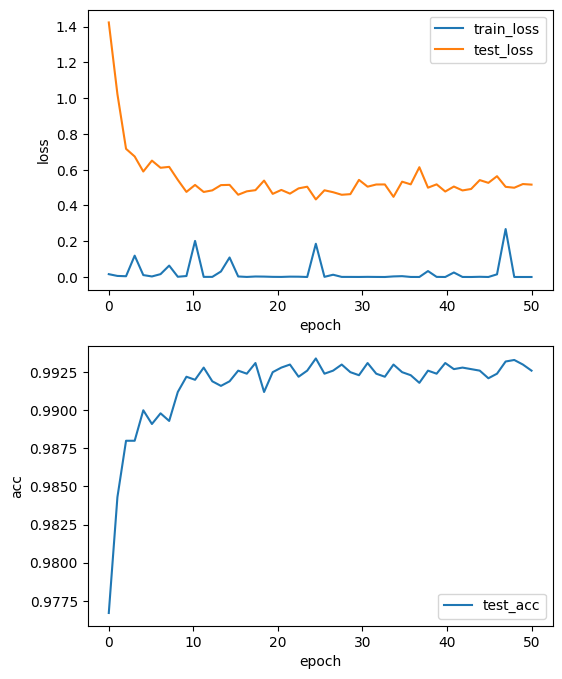

In [16]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# mpl.use('nbAgg')
# mpl.style.use('seaborn-darkgrid')
import numpy as np
def plotP(test_loss, train_loss, train_acc_list, test_acc_list):
    plt.figure(figsize=(6, 8))
    x = np.linspace(0,  len(train_loss))
    y = np.linspace(0, len(test_acc_list))
    plt.subplot(2, 1, 1)
    plt.plot(x, train_loss, label="train_loss")
    plt.plot(x, test_loss, label="test_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss") 
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(y, test_acc_list, label="test_acc")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.show()

plotP(loss2, loss, [], acc)